# Notebook: Metaphor analysis

This notebook is meant to analyse the metaphors detected by the REGEX and POS approaches.

The analysis will focus on:
- frequency of the word "inflation" related to the inflation rate
- Sentiment analysis of the metaphors flagged
- Poisson regression, with the metaphors sentiment score 

In [15]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from ecbdata import ecbdata

tqdm.pandas()

#ECB Color
color = (17/255, 49/255, 147/255)

In [16]:
# Target words:
words_to_match = ["inflation","deflation","inflationary","desinflationary","hyperinflation","disinflation"]

In [25]:
# Functions

# Function to count the frequency of words from the list in a sentence
def count_frequency(answer):
    sentence_lower = answer.lower()
    return sum(1 for word in words_to_match if word in sentence_lower)

In [26]:
# Import dataset containing the interveiw data
df = pd.read_csv('data_complete.csv')

# Convert 'date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# For computation speed, limit the data to the last 50 rows:
df = df.tail(50)

df.head()

,Date,Media,Member,Link,Information,Questions,Answers,list_regex,list_regex_reduced,list_regex_len,list_regex_reduced_len,text_length,pos_metaphors,pos_metaphors_len
469,2022-01-11,Interview with Il Sole 24 Ore,Philip R. Lane,https://www.ecb.europa.eu/press/inter/date/202...,"Interview with Philip R. Lane, Member of the E...",Euro area HICP inflation in December hit anoth...,11 January 2022[end_answer] In our December pr...,['in our December projection we assess that in...,['in our December projection we assess that in...,26,26,10329,"[('inflation', 'go'), ('inflation', 'fall'), (...",9
470,2022-01-07,Interview with RTÉ,Philip R. Lane,https://www.ecb.europa.eu/press/inter/date/202...,"Interview with Philip R. Lane, Member of the E...","Philip Lane, what's your response to the Euros...",7 January 2022[end_answer] That number is broa...,['we ve be clear in recent week and month that...,['we ve be clear in recent week and month that...,30,30,11108,"[('low', 'inflation'), ('inflation', 'go'), ('...",9
471,2023-12-22,Interview with Süddeutsche Zeitung,Isabel Schnabel,https://www.ecb.europa.eu/press/inter/date/202...,"Interview with Isabel Schnabel, Member of the ...","Inflation has recently fallen to 2.4%, more ra...",22 December 2023[end_answer] We will only be s...,['we will only be satisfied if inflation fall ...,['we will only be satisfied if inflation fall ...,21,21,7811,"[('inflation', 'fall'), ('inflation', 'drop'),...",9
472,2023-12-21,Interview with 20 Minutos,Luis de Guindos,https://www.ecb.europa.eu/press/inter/date/202...,"Interview with Luis de Guindos, Vice-President...",Wage cost data in Spain point to an increase o...,21 December 2023[end_answer] A year ago inflat...,['a year ago inflation be above and now it be ...,['a year ago inflation be above and now it be ...,12,12,9440,"[('inflation', 'fight'), ('inflation', 'slow')...",4
473,2023-12-05,Interview with Reuters,Isabel Schnabel,https://www.ecb.europa.eu/press/inter/date/202...,"Interview with Isabel Schnabel, Member of the ...",What is your take on the unexpectedly benign N...,5 December 2023[end_answer] “When the facts ch...,['over the past year headline inflation have d...,['over the past year headline inflation have d...,20,19,11805,"[('inflation', 'decline'), ('inflation', 'fall...",3


In [27]:
print("Shape of the dataset before dropping missing values: ", df.shape)
df.isna().sum()

Shape of the dataset before dropping missing values:  (50, 14)


Date                      0
Media                     0
Member                    0
Link                      0
Information               0
Questions                 2
Answers                   0
list_regex                0
list_regex_reduced        0
list_regex_len            0
list_regex_reduced_len    0
text_length               0
pos_metaphors             0
pos_metaphors_len         0
dtype: int64

In [28]:
print("Shape of the dataset after dropping missing values: ", df.shape)
df.nunique()

Shape of the dataset after dropping missing values:  (50, 14)


Date                      50
Media                     42
Member                     6
Link                      50
Information               50
Questions                 48
Answers                   50
list_regex                48
list_regex_reduced        48
list_regex_len            32
list_regex_reduced_len    28
text_length               50
pos_metaphors             43
pos_metaphors_len         13
dtype: int64

In [29]:
#types of data
df.dtypes

Date                      datetime64[ns]
Media                             object
Member                            object
Link                              object
Information                       object
Questions                         object
Answers                           object
list_regex                        object
list_regex_reduced                object
list_regex_len                     int64
list_regex_reduced_len             int64
text_length                        int64
pos_metaphors                     object
pos_metaphors_len                  int64
dtype: object

In [31]:
# Count the frequency of words from the list words_to_match
df["Frequency"] = df["Answers"].apply(count_frequency)


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


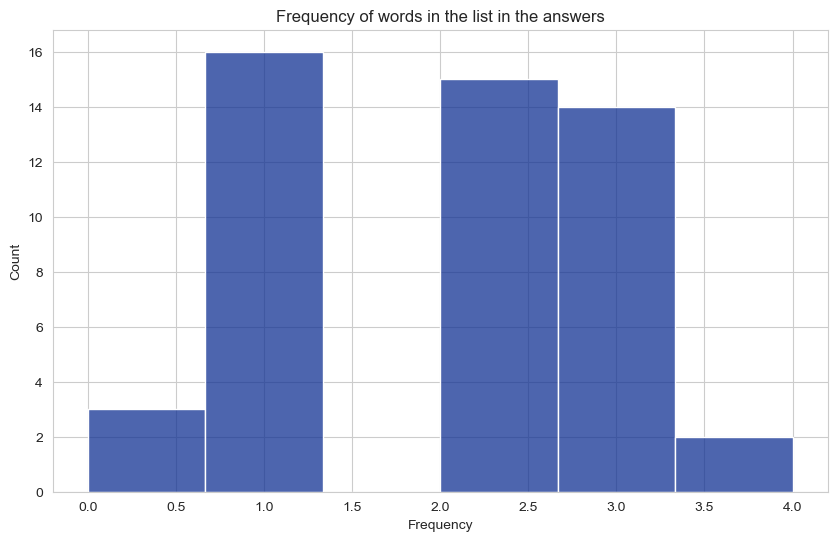

In [32]:
# Plot the frequency of the words
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
sns.histplot(df["Frequency"], color=color, bins=6)
plt.title("Frequency of words in the list in the answers")
plt.xlabel("Frequency")
plt.ylabel("Count")
plt.show()